In [1]:
import os
import yaml
import time
import torch 
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import joblib
from geopy.distance import geodesic
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split 
import numpy as np
from scipy.special import boxcox1p, inv_boxcox

# Personnal function
from functions_models import point_space_boundaries
from functions_models.collect_mini_cubes import *
from functions_models.apply_transformation import apply_transformation
from functions_models.fill_nan_with_mean import fill_nan_with_mean
from functions_models.add_current import add_current
from functions_models.apply_bathy_mask import apply_bathy_mask
from functions_models.usefull_function_model import *
from functions_models.build_data_loader import build_data_loader
from functions_models.models_archi import *
from functions_models.create_new_training_folder import *
from functions_models.evaluate_model import *

In [12]:
# ¨Parameters that you don't change
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = "from_pfts_study_reset17072025"
image_size = 16
date_buffer = 1
space_buffer = int(image_size/2)
threshold = 0.99
model = 1
pfts = True 

#Hyper parameters 
learning_rate = 10e-4
batch_size = 100
nb_epoch = 6000


nb_training = 1

# Parameters for scatter plot 
main_title = f'MLP on {image_size}x{image_size} km with optics input'
y_label_name = f'MLP'
model_save_name = "MLP_1.pth"


# Load data 
path_dico = f"./dataset/{dataset}/space_buffer_{space_buffer}_date_buffer_1/threshold_{threshold}"
train_loader, valid_loader, test_loader, df_mini_cubes = build_data_loader(image_size, model, pfts, 'cpu', batch_size, dataset, path_dico, threshold)
criterion = nn.MSELoss()



In [13]:
mode = 1
if mode == 1:
    model_dl = DNN(6, [70,50], 3, device,p=0.1)
elif mode == 2:
    model_dl = DNN(14, [100,50], 2, device,p=0.3) 
elif mode == 3:
    print("not implemented yet")

model_dl.to(device)
optimizer = optim.Adam(model_dl.parameters(), lr=learning_rate)

In [14]:
import torch 
import copy
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def train_val_loop_l2(device, nb_epoch, model_dl, dataloader_train, dataloader_val,
                   optimizer, criterion, loss_diff_threshold, model,
                    patience=50,
                   use_penalty=False, penalty_type="L2", penalty_lambda=7*1e-4):
    """
    Custom training loop for PFTs prediction. Computes MSE for micro, nano, and pico.
    Inputs:
        prediction_train_tchla: tensor of TCHLA predictions for train set
        prediction_val_tchla: tensor of TCHLA predictions for val set
    """

    model_dl.to(device)

    LOSS_TRAIN = []
    LOSS_VAL = []
    list_val = []
    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model_dl.state_dict())
    epoch_iterator = tqdm(range(nb_epoch), desc="Training epochs")

    for epoch in epoch_iterator:
        total_loss_train = 0
        model_dl.train()
        idx_train = 0
        for X_batch, Y_batch, _ in dataloader_train:
            if model != 3:
                X_batch[X_batch == -10] = float('nan')
                X_batch = X_batch.nanmean(dim=(2, 3))

            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            prediction = model_dl(X_batch.float()) 
            micro_pred = prediction[:, 0].view(-1, 1)
            nano_pred = prediction[:, 1].view(-1, 1)
            pico_pred = prediction[:, 2].view(-1, 1)
            
            prediction_tensor = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
            truth_tensor = Y_batch[:, :3]

            # Appliquer le critère sur tout le tensor
            loss = criterion(prediction_tensor, truth_tensor)

            # Add L2 penalty
            if use_penalty and penalty_type == "L2":
                l2_penalty = sum(torch.sum(param**2) for param in model_dl.parameters())
                loss += penalty_lambda * l2_penalty

            loss.backward()
            total_loss_train += loss.item()
            optimizer.step()
            idx_train += len(X_batch)

        average_loss_train = total_loss_train / len(dataloader_train)
        LOSS_TRAIN.append(average_loss_train)

        if (epoch + 1) % 2 == 0:
            total_loss_val = 0
            model_dl.eval()
            idx_val = 0
            with torch.no_grad():
                for X_batch_val, Y_batch_val, _ in dataloader_val:
                    if model != 3:
                        X_batch_val[X_batch_val == -10] = float('nan')
                        X_batch_val = X_batch_val.nanmean(dim=(2, 3))

                    X_batch_val, Y_batch_val = X_batch_val.to(device), Y_batch_val.to(device)
                    prediction_val = model_dl(X_batch_val.float())
                    micro_pred = prediction_val[:, 0].view(-1, 1)
                    nano_pred = prediction_val[:, 1].view(-1, 1)
                    pico_pred = prediction_val[:, 2].view(-1, 1)
                                        
                    # Concaténer les trois prédictions
                    prediction_tensor = torch.cat([micro_pred, nano_pred, pico_pred], dim=1)
                    truth_tensor = Y_batch_val[:, :3]

                    # Appliquer le critère sur tout le tensor
                    loss_val = criterion(prediction_tensor, truth_tensor)
                    total_loss_val += loss_val.item()
                    idx_val += len(X_batch_val)

            average_loss_val = total_loss_val / len(dataloader_val)
            LOSS_VAL.append(average_loss_val)
            list_val.append(average_loss_val)

            if average_loss_val < best_val_loss:
                best_val_loss = average_loss_val
                best_model_state = copy.deepcopy(model_dl.state_dict())

        if len(LOSS_TRAIN) >= patience and (epoch + 1) % 2 == 0:
            recent_losses = LOSS_VAL[-patience:]
            if max(recent_losses) - min(recent_losses) < loss_diff_threshold:
                print(f'Early stopping at epoch {epoch + 1} due to minimal change in validation loss over the last {patience} epochs')
                break

    model_dl.load_state_dict(best_model_state)

    return LOSS_TRAIN, LOSS_VAL, list_val, model_dl




In [15]:
loss_diff_threshold = 0.002
LOSS_TRAIN, LOSS_VAL, list_val, model_trained = train_val_loop_l2(device, nb_epoch, model_dl, train_loader, valid_loader,
                   optimizer, criterion, loss_diff_threshold, model,
                   patience=50,
                   use_penalty=False, penalty_type="L2", penalty_lambda=7*1e-4)

Training epochs: 100%|██████████| 6000/6000 [13:45<00:00,  7.27it/s]


Plot saved as:
  • ./training_new_prediction_3output/model_1/space_buffer_8_date_buffer_1/train_pfts_1.png
  • ./training_new_prediction_3output/model_1/space_buffer_8_date_buffer_1/train_pfts_1.pdf


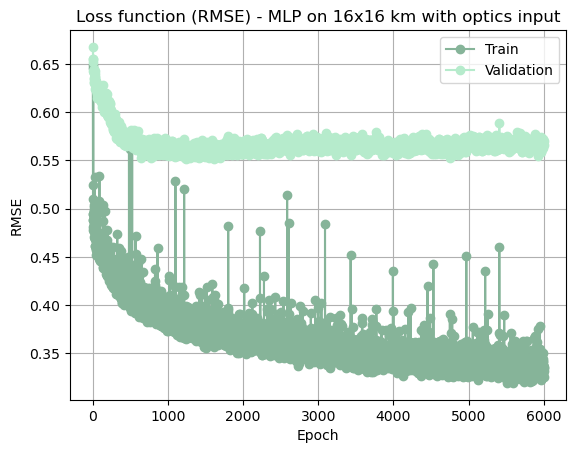

In [20]:
#make a save file 

training_name = "new_prediction_3output"
path_save = f"./training_{training_name}/model_{model}/space_buffer_{space_buffer}_date_buffer_{date_buffer}"
path_save_all = create_new_training_folder(path_save, pfts)

plot_loss(LOSS_TRAIN, LOSS_VAL, main_title, path_save_all, "RMSD")

In [ ]:
def evaluate_model(dataloader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix, set_type):
    # Map pour filtrage selon set_type
    set_code_map = {'train': 0, 'val': 1, 'test': 2}
    set_code = set_code_map[set_type]

    model_trained.eval()
    prediction_set = []
    true_set = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(device)
            if model != 3:
                images[images == -10] = float('nan')
                images = images.nanmean(dim=(2, 3))
            outputs = model_trained(images.float())
            prediction_set.append(outputs.cpu())
            true_set.append(labels.cpu())

    prediction_set = torch.cat(prediction_set, dim=0)
    true_set = torch.cat(true_set, dim=0)

    df_set = df_mini_cubes[df_mini_cubes[:, 9] == set_code]
    df_set_lat = df_set[:, 0]

    if pfts:
        keys = ["Micro_Chla", "Nano_Chla", "Pico_Chla"]
        short_keys = ["micro", "nano", "pico"]
    
        predictions = {}
        truths = {}
    
        json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
        with open(json_path, "r") as f:
            dico = json.load(f)
    
        for i, key in enumerate(keys):
            short_key = short_keys[i]
            true_i = true_set[:, i].detach().cpu().numpy().reshape(-1, 1)
            pred_i = prediction_set[:, i].detach().cpu().numpy().reshape(-1, 1)

            # Load parameters for transformation
            if data_to_use == "quantile":
                transfo_path = os.path.join(path_dico, f"{key}_quantile_transformer.pkl")
                if not os.path.exists(transfo_path):
                   raise FileNotFoundError(f"Missing transformer: {transfo_path}")
                transformer = joblib.load(transfo_path)
    
                pred_i = transformer.inverse_transform(pred_i).flatten()
                true_i = transformer.inverse_transform(true_i).flatten()

            elif data_to_use == "boxcox": 
                # Déstandardisation
                mean = dico[f"{key}_standardization_mean"]
                std = dico[f"{key}_standardization_std"]
                pred_i = pred_i * std + mean
                true_i = true_i * std + mean
    
                # Déboxcox
                lmbda = dico[f"{key}_boxcox_lmbda"]
                pred_i = inv_boxcox(pred_i, lmbda)
                true_i = inv_boxcox(true_i, lmbda)

                # Thresholrd
                pred_i = pred_i - 10e-4
                true_i = true_i - 10e-4

            pred_i[pred_i < 0.0001] = 0.0001
            true_i[true_i < 0.0001] = 0.0001
            predictions[short_key] = pred_i.tolist()
            truths[short_key] = true_i.tolist()

        # Plot PFT
        for pft in short_keys:
            x_label = f'HPLC {pft}-Chla (mg.m$^{{-3}}$)'
            y_label = f'{y_label_name} \n {pft}-Chla (mg.m$^{{-3}}$)'
            output_file = os.path.join(path_save_all, f'{pft}_{suffix}_plot.png')

            plot_score2(
                predictions[pft],
                truths[pft],
                main_title,
                df_set_lat,
                output_link=output_file,
                axis_log=True,
                xlabel=x_label,
                ylabel=y_label,
                PFTS=True
            )
    else:
        key = "TChla"
        short_key = "tchla"
    
        predictions = {}
        truths = {}
    
        json_path = os.path.join(path_dico, "dico_lambda_MLP.json")
        with open(json_path, "r") as f:
            dico = json.load(f)
        prediction_set = prediction_set.cpu().numpy().reshape(-1, 1)
        true_set = true_set.cpu().numpy().reshape(-1, 1)

        if data_to_use == "quantile":
            TChla_path = os.path.join(path_dico, "TChla_quantile_transformer.pkl")
            quantile_transformer = joblib.load(TChla_path)

            predictions = quantile_transformer.inverse_transform(prediction_set)
            truths = quantile_transformer.inverse_transform(true_set)
        
        elif data_to_use == "boxcox": 
            # Déstandardisation
            mean = dico[f"{key}_standardization_mean"]
            std = dico[f"{key}_standardization_std"]
            pred_i = prediction_set * std + mean
            true_i = true_set * std + mean
    
            # Déboxcox
            lmbda = dico[f"{key}_boxcox_lmbda"]
            pred_i = inv_boxcox(pred_i, lmbda)
            true_i = inv_boxcox(true_i, lmbda)
    

        x_label = f'HPLC Total-Chla (mg.m$^{{-3}}$)'
        y_label = f'{y_label_name} \n Total-Chla (mg.m$^{{-3}}$)'
        output_file = os.path.join(path_save_all, f'tchla_{suffix}_plot.png')
        plot_score2(pred_i, true_i , main_title, df_set_lat, output_link=output_file, axis_log=True, xlabel=x_label, ylabel=y_label)

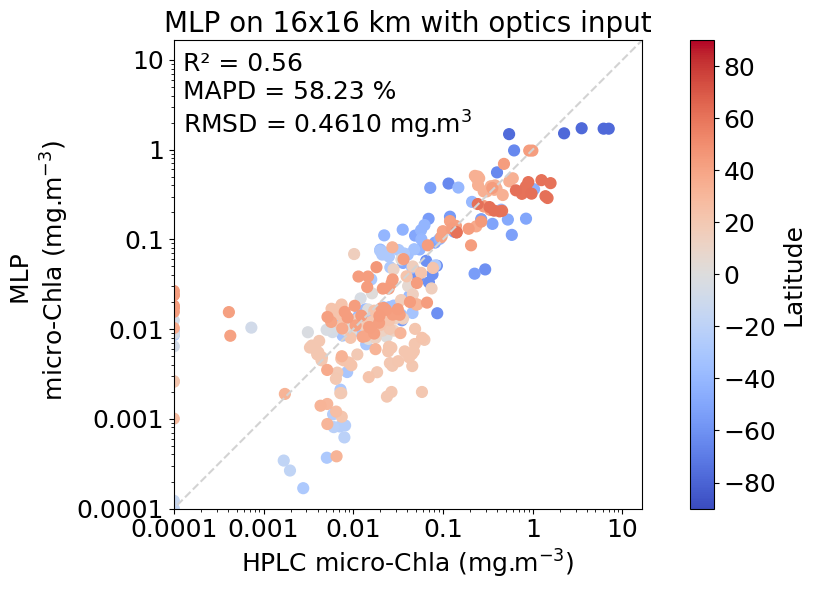

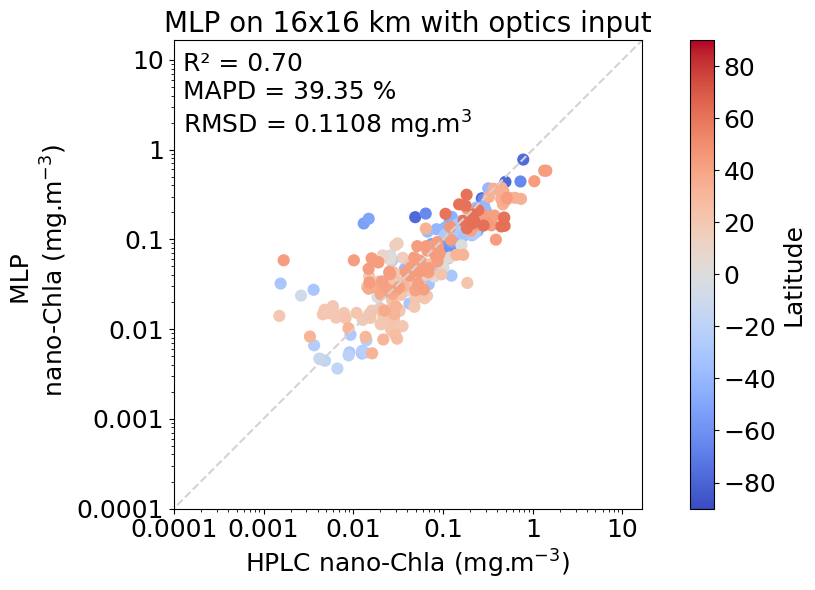

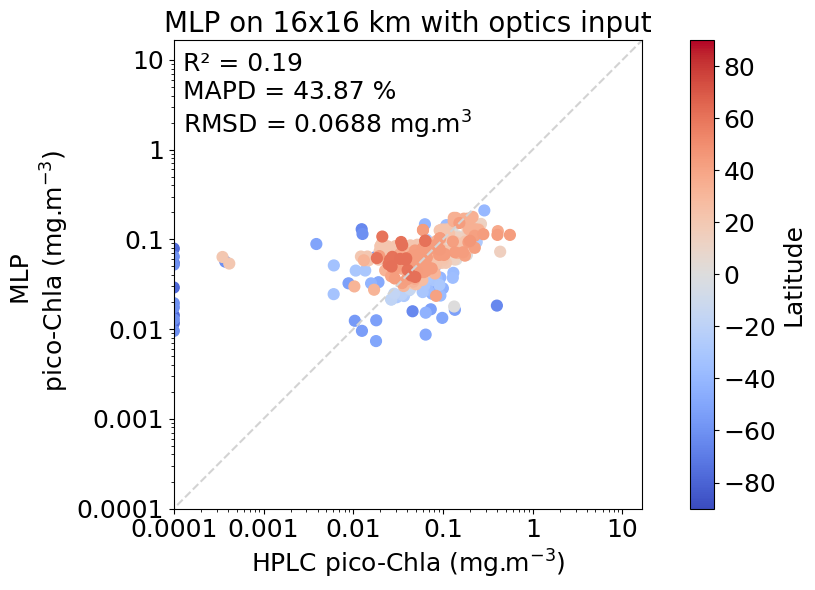

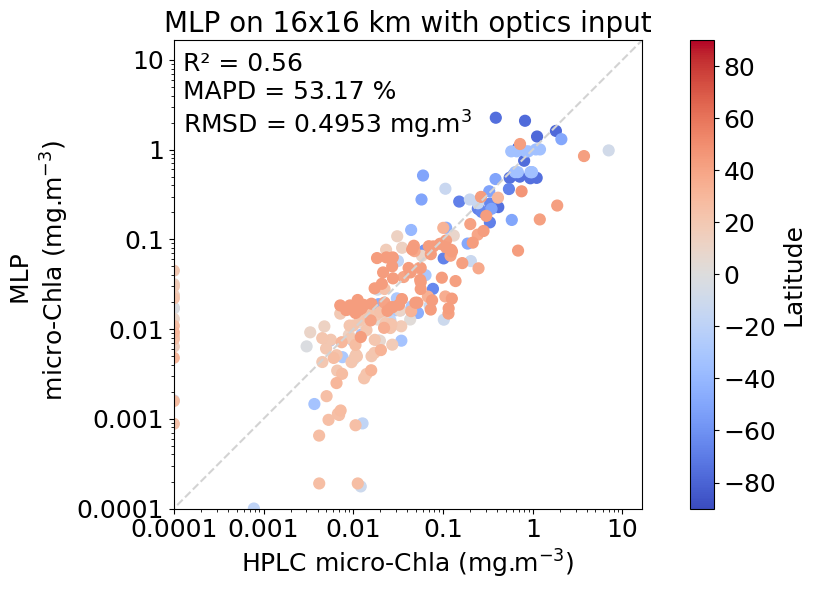

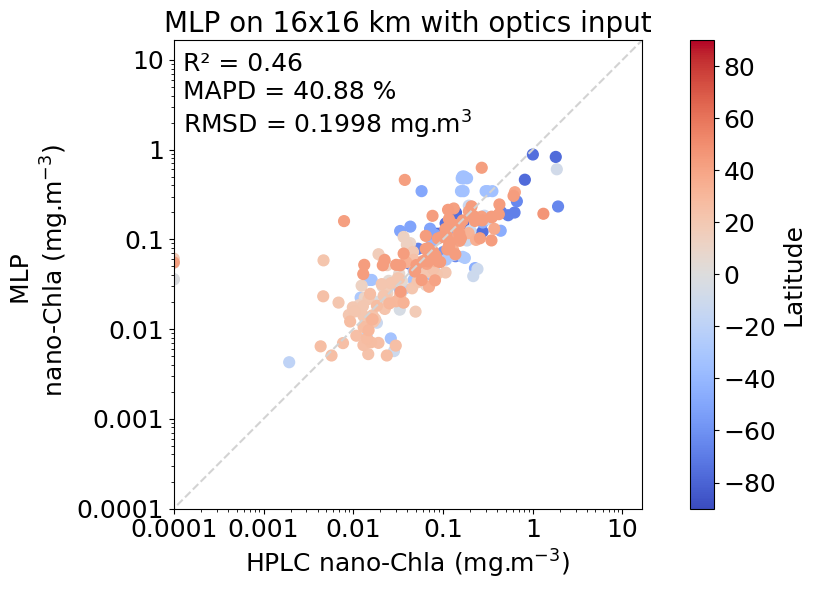

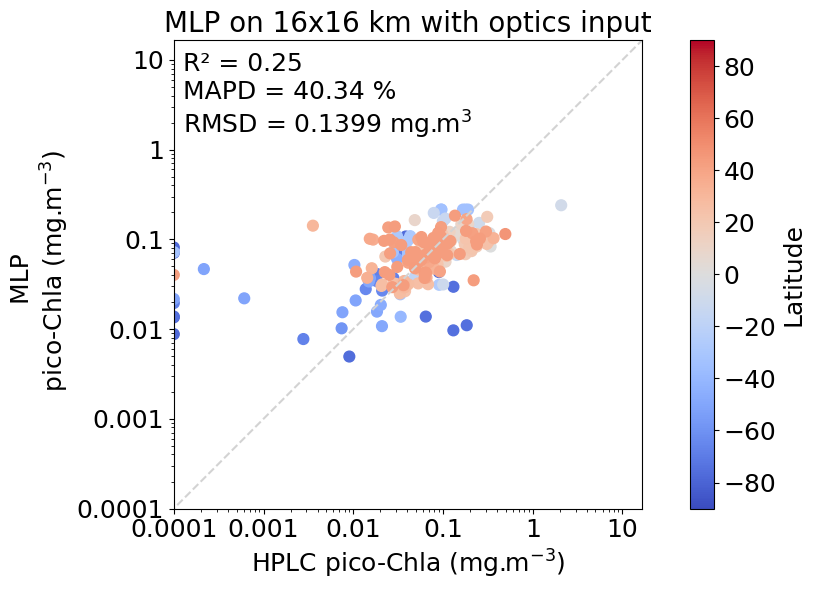

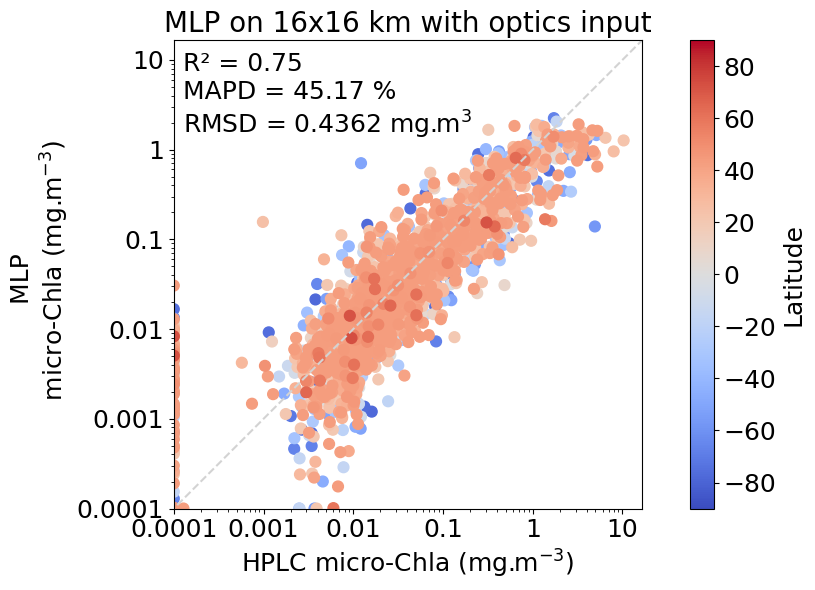

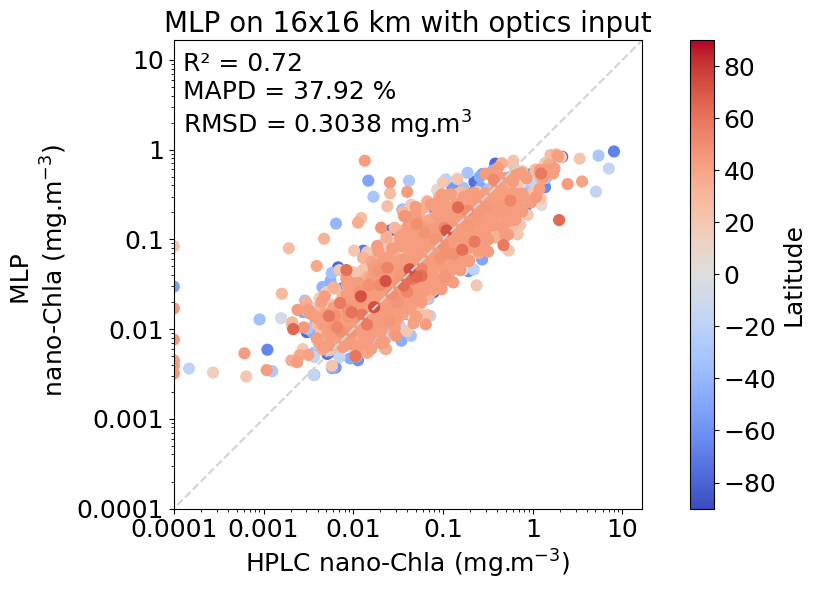

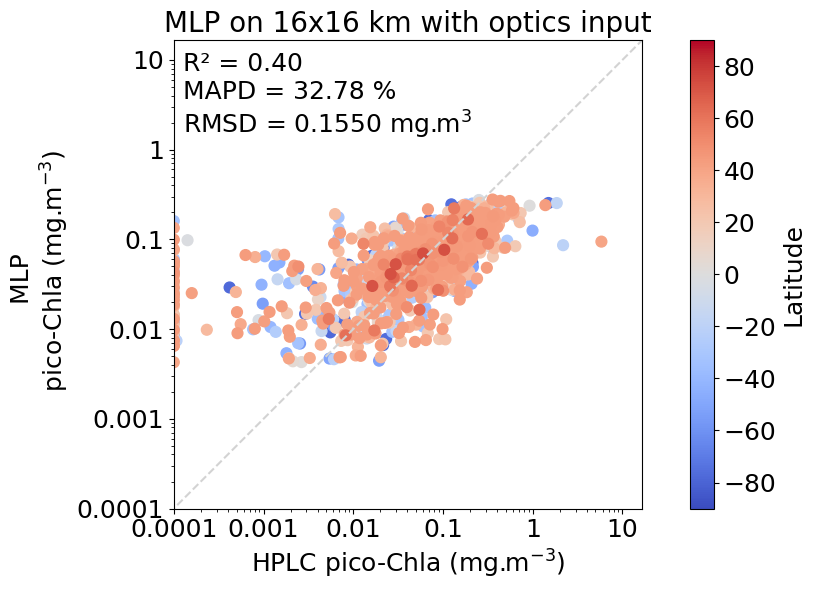

In [22]:
data_to_use = "boxcox"

evaluate_model(test_loader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="test", set_type="test")
evaluate_model(valid_loader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="val", set_type="val")
evaluate_model(train_loader, model_trained, model, device, pfts, path_dico, df_mini_cubes, y_label_name, main_title, path_save_all, data_to_use, suffix="train", set_type="train")


In [9]:
model_save_name = "MLP.pth"
model_save_path = os.path.join(path_save_all, model_save_name)
torch.save({
        'epoch': nb_epoch, 
        'model_state_dict': model_trained.state_dict(), 
        'optimizer_state_dict': optimizer.state_dict() }, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./training_new_loss_pico_soustraction/model_1/space_buffer_8_date_buffer_1/train_pfts_16/MLP.pth
